#Homework 2 - RNN

Use the attached dataset elecdaily_mm.csv with a test set from January 2021 onwards.

Create a neural network that can generate:
1) a 1-day ahead direct forecast
2) a 7-day ahead direct forecast
3) daily forecasts for the next 7 days

For each, what is your model's test MAE? Can you beat an MAE of 3?

## Verify Setup

In [1]:
import torch
import tensorflow as tf

# Check PyTorch CUDA Version
print("PyTorch CUDA Version:")
try:
    print(torch.version.cuda)
except AttributeError:
    print("CUDA not available with this PyTorch installation.")

# Check TensorFlow CUDA Version
print("\nTensorFlow CUDA Version:")
try:
    print(tf.sysconfig.get_build_info()['cuda_version'])
except KeyError:
    print("CUDA not used in this TensorFlow build.")

# Additional checks for GPU availability
print("\nGPU Availability:")
print("PyTorch CUDA Availability:", torch.cuda.is_available())
print("TensorFlow GPU Devices:", len(tf.config.list_physical_devices('GPU')) > 0)


PyTorch CUDA Version:
None

TensorFlow CUDA Version:
CUDA not used in this TensorFlow build.

GPU Availability:
PyTorch CUDA Availability: False
TensorFlow GPU Devices: True


## Import Data

In [2]:
import os

fname =  'elecdaily_mm.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['Date', 'GW']
1582


In [10]:
import pandas as pd

data2 = pd.read_csv(fname)
dummy=data2
dummy.head()

,Date,GW
0,01/01/2017,48.4960
1,01/02/2017,54.4959
2,01/03/2017,69.6240
3,01/04/2017,72.6467
4,01/05/2017,72.4765


In [11]:
dummy['Date'] = pd.to_datetime(dummy['Date'], format='%m/%d/%Y')

dummy = dummy.sort_values(by='Date')

dummy.head()

,Date,GW
0,2017-01-01,48.4960
1,2017-01-02,54.4959
2,2017-01-03,69.6240
3,2017-01-04,72.6467
4,2017-01-05,72.4765


In [18]:
dummy.tail()

,Date,GW
1576,2021-04-26,74.7433
1577,2021-04-27,73.9165
1578,2021-04-28,75.5943
1579,2021-04-29,78.4968
1580,2021-04-30,80.7664


In [12]:
data2.shape

(1581, 2)

## Visualize the Data

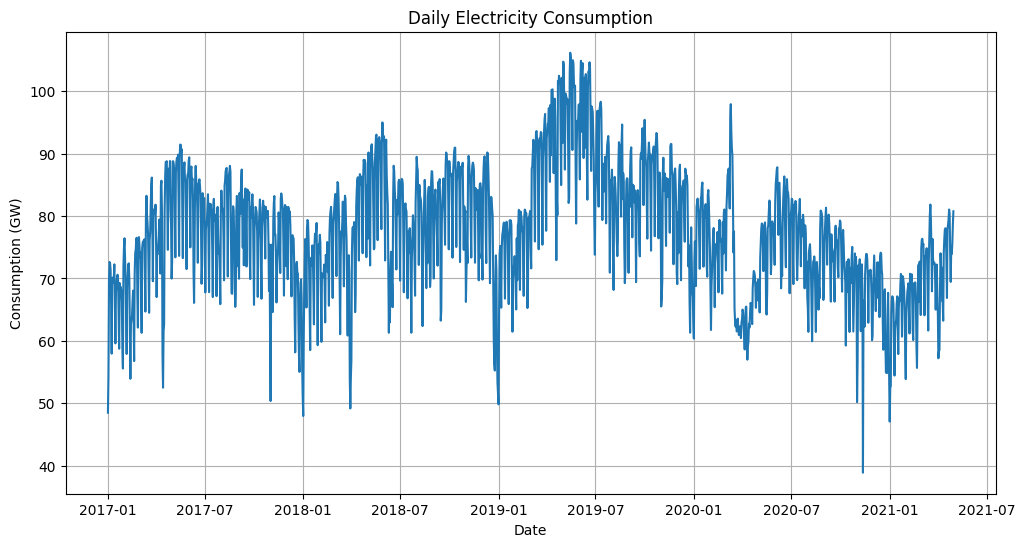

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

# Plotting GW consumption against Date
plt.figure(figsize=(12, 6)) # Optional: Adjust figure size for better readability
plt.plot(data2['Date'], data2['GW'])
plt.xlabel('Date')
plt.ylabel('Consumption (GW)')
plt.title('Daily Electricity Consumption')
plt.grid(True) # Optional: Add grid for better readability
plt.show()

## Normalize the Data

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extract the 'GW' column to normalize
gw_values = data2['GW'].values.reshape(-1, 1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
normalized_gw = scaler.fit_transform(gw_values)

# Update the 'GW' column in the DataFrame with normalized values
data2['GW'] = normalized_gw

# Display the first few rows with normalized data
print(data2.head())

# Keep the scaler object for inverse transformation later
print("\nScaler object created and fitted.")

## Sampling the Data

In [17]:
import torch
import numpy as np
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback, delay, min_index, max_index, step):
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.min_index = min_index
        self.max_index = max_index if max_index is not None else len(data) - delay - 1
        self.step = step

    def __len__(self):
        return self.max_index - self.min_index - self.lookback + 1

    def __getitem__(self, index):
        i = self.min_index + index + self.lookback
        indices = range(i - self.lookback, i, self.step)
        samples = self.data[indices]
        target = self.data[i + self.delay][1]  # second column (index 1) is the target variable

        return torch.tensor(samples, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

## Prepare the Train and Test Sets

In [24]:
from torch.utils.data import DataLoader

NUM_WORKERS = 1

lookback = 10 #10 days lookback at 1 sample per day
step = 1
delay = 1 # Predict the next value
batch_size = 128

train_dataset = TimeSeriesDataset(data2, lookback, delay, 0, 200000, step)
val_dataset = TimeSeriesDataset(data2, lookback, delay, 200001, 300000, step)
test_dataset = TimeSeriesDataset(data2, lookback, delay, 300001, None, step)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

## Evaluate Naive Method

In [25]:
def evaluate_naive_method(loader):
    maes = []
    for samples, targets in loader:
        preds = samples[:, -1, 1]  # last time step's temperature as prediction
        mae = torch.mean(torch.abs(preds - targets))
        maes.append(mae.item())
    return np.mean(maes)

# Evaluate
naive_mae = evaluate_naive_method(val_loader)
print(f"Naive method MAE on validation set: {naive_mae}")

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/miniconda3/envs/mltfpy39/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/miniconda3/envs/mltfpy39/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TimeSeriesDataset' on <module '__main__' (built-in)>


RuntimeError: DataLoader worker (pid(s) 6807) exited unexpectedly